In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/SW엔지니어

/content/drive/MyDrive/Colab Notebooks/SW엔지니어


#### 목표
- mlp, cnn 모델 활용 이미지 분류 실습
- 이진 분류
- 성능을 높이기 위한 방법들을 진행
  - 이미지 증식(확장)
  - 전이학습

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# 데이터 불러오기
data = np.load('./data/np_cat_vs_dog.npz')

In [6]:
len(data)

4

In [7]:
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2000, 224, 224, 3) (1000, 224, 224, 3) (2000,) (1000,)


MLP(다층퍼셉트론) 모델링 수행
1. 신경망 구조 설계
2. 학습 방법 설정
3. 학습
4. 시각화

In [8]:
# 환경세팅을 위한 라이브러리
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten # Flatten : 다차원 > 1차원
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
# 1. 설계
mlp_model = Sequential()

# 입력층
# mlp_model.add(inputLayer(shape=(224,224,3)))
mlp_model.add(Flatten(input_shape=(224,224,3)))

# 은닉층
mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dense(64, activation='relu'))

# 출력층 : 이진분류 > sigmoid
mlp_model.add(Dense(1, activation='sigmoid'))

# 2. 학습방법 설정
mlp_model.compile(loss='binary_crossentropy', # 손실함수 binary_crossentropy : 이진분류
                  optimizer='adam', # 최적화 함수
                  metrics=['accuracy'])

# 2-1. 조기학습 중단
early = EarlyStopping(monitor = 'val_accuracy', patience = 5, verbose = 1) # 모델의 개선이 없을 시 5번까지 반복 후 종료

# 3. 학습
# 조기학습 중단 연결
mlp_his = mlp_model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=40,
                        verbose=1,
                        callbacks=[early]) # 조기학습 중단

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5116 - loss: 2999.1296 - val_accuracy: 0.9975 - val_loss: 0.9305
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5229 - loss: 462.4910 - val_accuracy: 0.0000e+00 - val_loss: 1666.3405
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5800 - loss: 260.3708 - val_accuracy: 0.5950 - val_loss: 51.2211
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5678 - loss: 302.1342 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5083 - loss: 761.9360 - val_accuracy: 0.4625 - val_loss: 154.3330
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5545 - loss: 162.1304 - val_accuracy: 0.0375 - val_loss: 253.6819
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5752 - loss: 140.2971 - val_accuracy: 0.1400 - val_loss: 97.8224
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6093 - loss: 3

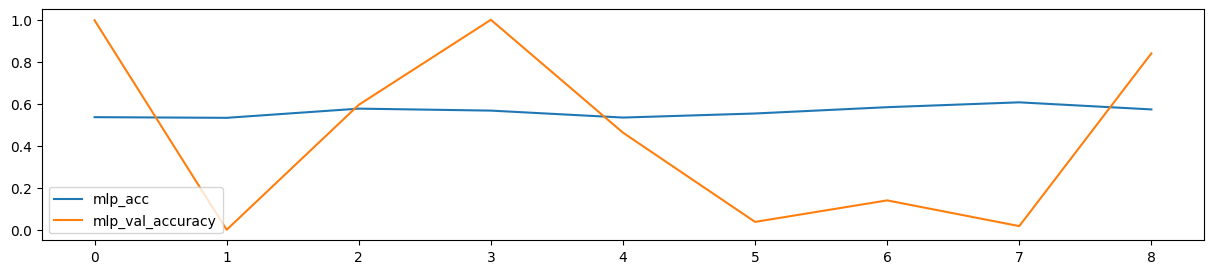

In [10]:
# mlp_his 시각화
plt.figure(figsize=(15,3))

plt.plot(mlp_his.history['accuracy'], label='mlp_acc')
plt.plot(mlp_his.history['val_accuracy'], label='mlp_val_accuracy')
plt.legend()
plt.show()

In [10]:
# 모델이 학습 자체를 제대로 하지 못한 상황
# 복작한 데이터에 비해, 모델이 단순한 상황
# mlp 특성상 이미지에 대한 학습 성능이 떨어짐.
# 이미지에 대한 파악을 잘 할 수 있게 해보자 > 특성 추출 > 학습 : CNN

#### CNN 모델 생성
1. 모델 설계
  - 뼈대 구축
  - 특성 추출부(합성곱)
  - 분류부
2. 모델 컴파일
3. 학습 및 시각화
4. 예측 및 평가

#### 필요한 라이브러리 import

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

# Conv2D : 데이터의 특징을 잡아내는 역할(컨볼루셔널 레이어)
# MaxPooling2D : 중요한 정보만 걸러내는 역할(풀링 레이어)

In [24]:
# 1. 설계
cnn_model = Sequential()

# 입력층
cnn_model.add(InputLayer(input_shape=(224,224,3)))

# *** 특징 추출부 ***
cnn_model.add(Conv2D(
  filters = 32, # 커널의 개수, 탐지하는 눈의 개수
  kernel_size = (3,3), # 커널의 크기, 탐지하는 눈의 크기
  activation = 'relu',
  padding = 'same', # 패딩 : 입출력의 크기를 동일하게 하기 위해 가장자리에 0을 채우겠다
                   # 이미지 자체가 작거나, 갖아자리에 중요한 정보가 있는 경우 : same > 커널이 밖으로 나갈 경우 0으로 채워짐
                   # 이미지 자체가 크거나, 특징이 많을 때 : valid > 커널이 밖으로 못나감
  strides = (2,2)  # 보폭, 컨러이 양 옆과 위 아래로 2픽셀씩 이동 : 커널의 보폭
))

cnn_model.add(MaxPooling2D(
    pool_size = (2,2) # 풀링 윈도우 지정
    # 이미지 탐색에서 그 이미지의 특정 위치의 특징을 요구하는 픽셀 크기 지정
))

cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu',padding = 'same', strides = (2,2)))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu',padding = 'same', strides = (2,2)))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))

# 분류부
cnn_model.add(Flatten()) # 차원축소
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(64, activation='relu'))
# 출력층
cnn_model.add(Dense(1, activation='sigmoid'))

# 2. 학습방법 설정
cnn_model.compile(loss='binary_crossentropy',
                  optimizer='adam', # 최적화 함수
                  metrics=['accuracy'])

# 3. 학습
cnn_his = cnn_model.fit(X_train, y_train,
                        validation_split=0.3,
                        epochs=20,
                        verbose=1,
                        batch_size=64,
                        )

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.5694 - loss: 8.6404 - val_accuracy: 0.2050 - val_loss: 0.9780
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6821 - loss: 0.6350 - val_accuracy: 0.0000e+00 - val_loss: 1.3341
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6944 - loss: 0.6224 - val_accuracy: 0.0467 - val_loss: 1.0600
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7086 - loss: 0.5920 - val_accuracy: 0.0050 - val_loss: 1.2294
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7180 - loss: 0.5861 - val_accuracy: 0.0550 - val_loss: 1.2908
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7236 - loss: 0.5452 - val_accuracy: 0.3050 - val_loss: 0.8417
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7140 - loss: 0.5871 - val_accuracy: 0.0300 - val_loss: 1.4407
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7321 - loss: 0.5446 - val_accuracy: 0.091

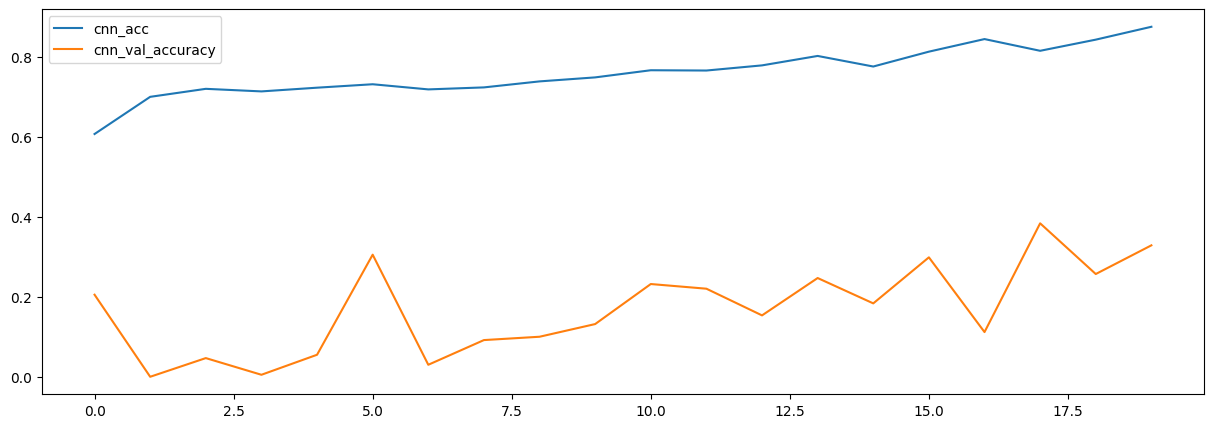

In [26]:
# 시각화
# cnn_his 시각화
plt.figure(figsize=(15,5))

plt.plot(cnn_his.history['accuracy'], label='cnn_acc')
plt.plot(cnn_his.history['val_accuracy'], label='cnn_val_accuracy')
plt.legend()
plt.show()

In [10]:
# 과대적합이 일어난다.
# 성능의 일반화가 mlp보다는 좋다.

# >> 과대적합 해소, 일반화 성능 향상

#### 데이터 이미지 증강(증식, 확장)을 통한 cnn모델 성능 개선
- 데이터 증강 : 이미지 회전, 이동, 확대, 축소 등을 통해 데이터를 늘리는 작업
- 과대적합이 일어나는 이유 중 하나는 훈련데이터의 부족.
- 훈련데이터가 충분하다면, 과대적합을 줄일 수 있다.
- 데이터 확장이란 훈련데이터를 다양하게 변형하여 변형된 새로운 훈련데이터를 사용하므로써 마치 훈련데이터의 수가 늘어난 효과를 얻는 것.

* 주의사항
- 증강은 '훈련데이터'에서만 진행

In [27]:
# 이미지 크기 조절, 픽셀값 변경, 라벨링, 이미지 데이터 증강 라이브러리
from tensorflow.keras.preprocessing.image import ImageDataGenerator

| 옵션               | 설명                                                       |
|--------------------|------------------------------------------------------------|
| `rescale`          | 입력 이미지의 픽셀 값 재조정(ex.rescale=1.255 -> 모든 픽셀값들에 대해 0~1 사이로 정규화)|
| `rotation_range`   | 이미지의 회전 범위를 설정(ex.rotation_range -> -20~20도 사이에서 무작위로 회전)|
| `width_shift_range`| 이미지의 수평 이동 범위를 설정(ex.0.1은 전체 너비의 10%만큼 좌우로 무작위로 이동) |
| `height_shift_range`| 이미지의 수직 이동 범위를 설정(ex.0.1은 전체 너비의 10%만큼 위아래로 무작위로 이동)|
| `shear_range`      | 시계 반대 방향으로 지정된 각도만큼 변형       |
| `zoom_range`       | 이미지의 확대 및 축소 범위를 설정(ex.0.1 -> 0.9배~1.1배 사이에서 무작위로 확대하거나 축소) |
| `horizontal_flip`  | 이미지를 수평 방향으로 뒤집을지 여부를 설정       |
| `fill_mode`        | 이미지를 변형할 때 생기는 빈 공간을 채우는 방식을 설정(ex.nearest -> 가장 가까운 픽셀값을 사용하여 빈공간 채우기) |


In [29]:
# 증강할 데이터 경로 설정
train_dir = './data/cats_and_dogs_filtered/train'
test_dir = './data/cats_and_dogs_filtered/test'

# 증강기 생성(변형할 형식 지정)
train_gen = ImageDataGenerator(rescale=1./255, # 이미지 픽셀 값을 0~1 범위로 스케일 정규화
                               zoom_range = 0.2, # 0.8배(감소) ~ 1.2(확대) 축소 및 확대
                               horizontal_flip = True # 좌우 반전
)

test_gen = ImageDataGenerator(rescale=1./255) # 테스트 데이터는 증강 X 정규화만 진행

In [34]:
# 이미지 데이터 제너레이터 생성
# flow_from_directory
# 지정된 디렉토리에서 이미지를 불러오고, 실시간으로 데이터를 생성하는 기능
train_generator = train_gen.flow_from_directory(
    train_dir, # 이미지가 저장된 디렉토리 경로
    target_size = (224,224), # 이미지 크기 고정
    batch_size = 32, # 한번에 변환할 이미지 개수
    class_mode = 'binary' # 이진분류 / categorical : 다중분류
)

test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Dropout
- 과대적합을 개선
- 학습하는 동안에만 적용
- 신경망을 비율에 따라 활성화 되지 않도록 꺼버림

In [32]:
# Dropout import
from tensorflow.keras.layers import Dropout

In [35]:
# 1. 설계
cnn_model2 = Sequential()

# 입력층
cnn_model2.add(InputLayer(input_shape=(224,224,3)))

# *** 특징 추출부 ***
cnn_model2.add(Conv2D(
  filters = 32,
  kernel_size = (3,3),
  activation = 'relu',
  padding = 'same',
  strides = (2,2)
))

cnn_model2.add(MaxPooling2D(pool_size = (2,2)))

#########
cnn_model2.add(Dropout(0.3)) # pool층에 의해 나온 특징지도(피쳐맵) 중 30%는 무작위로 0으로 만든 후 두번째 층으로 넘김
# 예측을 수행할 때에는 비활성화됨.

cnn_model2.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu',padding = 'same', strides = (2,2)))
cnn_model2.add(MaxPooling2D(pool_size = (2,2)))
cnn_model2.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu',padding = 'same', strides = (2,2)))
cnn_model2.add(MaxPooling2D(pool_size = (2,2)))

#########
cnn_model2.add(Dropout(0.3))

# 분류부
cnn_model2.add(Flatten())
cnn_model2.add(Dense(256, activation='relu'))

#########
cnn_model2.add(Dropout(0.3))

cnn_model2.add(Dense(128, activation='relu'))
cnn_model2.add(Dense(64, activation='relu'))
# 출력층
cnn_model2.add(Dense(1, activation='sigmoid'))

# 2. 학습방법 설정
cnn_model2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# 3. 학습
cnn_his2 = cnn_model2.fit(
                        ## X_train, y_train,
                        train_generator,
                        ## validation_split=0.3,
                        ########
                        validation_data = test_generator,  # split을 할 경우 증강이 적용되기 때문에, 별도의 검증용 데이터셋으로 진행하기를 권장
                        ########
                        epochs=20,
                        verbose=1,
                        batch_size=64,
                        )

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 592s 9s/step - accuracy: 0.4990 - loss: 0.6973 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 523ms/step - accuracy: 0.5123 - loss: 0.6931 - val_accuracy: 0.5010 - val_loss: 0.6922
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 531ms/step - accuracy: 0.5515 - loss: 0.6901 - val_accuracy: 0.5190 - val_loss: 0.6929
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 512ms/step - accuracy: 0.5249 - loss: 0.6934 - val_accuracy: 0.5850 - val_loss: 0.6860
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 515ms/step - accuracy: 0.5594 - loss: 0.6872 - val_accuracy: 0.6490 - val_loss: 0.6486
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 505ms/step - accuracy: 0.5737 - loss: 0.6732 - val_accuracy: 0.5620 - val_loss: 0.6797
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 532ms/step - accuracy: 0.5718 - loss: 0.6734 - val_accuracy: 0.5800 - val_loss: 0.6564
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 509ms/step - accuracy: 0.6474 - loss: 0.6281 - val_accura

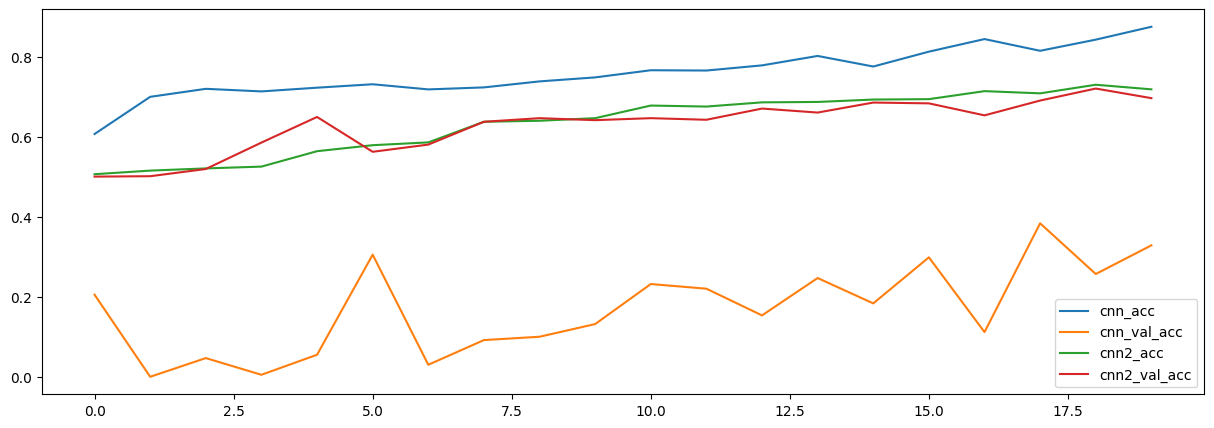

In [41]:
# cnn_his, cnn_his2 시각화
plt.figure(figsize=(15,5))
plt.plot(cnn_his.history['accuracy'], label='cnn_acc')
plt.plot(cnn_his.history['val_accuracy'], label='cnn_val_acc')
plt.plot(cnn_his2.history['accuracy'], label='cnn2_acc')
plt.plot(cnn_his2.history['val_accuracy'], label='cnn2_val_acc')
plt.legend()
plt.show()

In [36]:
# 이미지 증식을 통해 나름대로 과대적합이 해소된 것을 확인할 수 있음.
# 이미지 증식으로 모델 성능 개선
# 단점 : 학습 시간이 오래 걸림

### 전이학습
- 다른 사람이 만들어 놓은 모델을 사용해보자.

In [38]:
from tensorflow.keras.applications import VGG16
# 1000개 이상 다중분류

In [44]:
vgg16 = VGG16(include_top = False,
              weights = 'imagenet',
              input_shape = (224,224,3))

# top : 분류분기층, vgg16모델 : 다중분류(1000개)이므로 사용하지 않는다.(False) > 분류층은 따로 진행할 예정이다.
# weight : 'imagenet' << 데이터셋에서 사용한 가중치를 불러온다.

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [45]:
# 모든 conv층 동결, 가중치 갱신을 막아야함. -> 학습 불가능하게 설정
# vgg16 = 이미 100만장이상의 사진으로 학습이 되어있음. 성능이 좋음

# 특성 추출부 고정
for layer in vgg16.layers:
  layer.trainable = False # 훈련가능성 없음.

In [46]:
transfer_model = Sequential()
transfer_model.add(vgg16)

# 분류계층 작성 > mlp (이진분류: 강아지vs고양이)
transfer_model.add(Flatten())
transfer_model.add(Dense(64, activation='relu'))

transfer_model.add(Dense(1, activation='sigmoid'))

In [47]:
# 학습/평가 방법 설정
transfer_model.compile(loss = 'binary_crossentropy',
                       optimizer = 'Adam',
                       metrics = ['accuracy'])

In [48]:
# 학습
transfer_model_history = transfer_model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = 10,
    verbose = 1,
    batch_size = 64
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 779ms/step - accuracy: 0.6828 - loss: 1.0448 - val_accuracy: 0.8750 - val_loss: 0.2755
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 583ms/step - accuracy: 0.8969 - loss: 0.2536 - val_accuracy: 0.9160 - val_loss: 0.2129
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 666ms/step - accuracy: 0.9388 - loss: 0.1859 - val_accuracy: 0.9170 - val_loss: 0.2000
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 574ms/step - accuracy: 0.9520 - loss: 0.1405 - val_accuracy: 0.9250 - val_loss: 0.1902
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 657ms/step - accuracy: 0.9415 - loss: 0.1561 - val_accuracy: 0.8580 - val_loss: 0.3402
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 650ms/step - accuracy: 0.9269 - loss: 0.1585 - val_accuracy: 0.9200 - val_loss: 0.1839
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 577ms/step - accuracy: 0.9589 - loss: 0.1133 - val_accuracy: 0.8780 - val_loss: 0.3216
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 650ms/step - accuracy: 0.9534 - loss: 0.1058 - val_accu

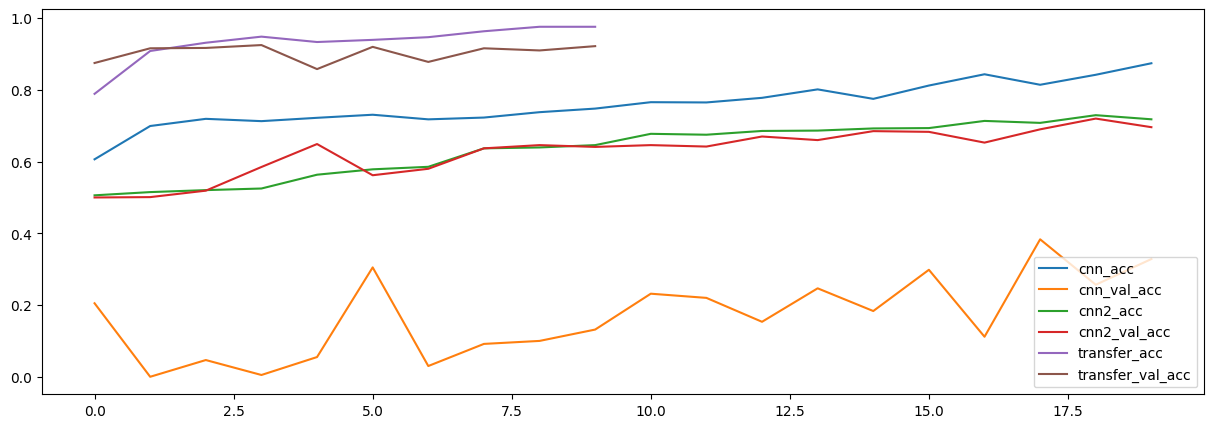

In [49]:
# cnn_his, cnn_his2, vgg16 모델 시각화
plt.figure(figsize=(15,5))
plt.plot(cnn_his.history['accuracy'], label='cnn_acc')
plt.plot(cnn_his.history['val_accuracy'], label='cnn_val_acc')
plt.plot(cnn_his2.history['accuracy'], label='cnn2_acc')
plt.plot(cnn_his2.history['val_accuracy'], label='cnn2_val_acc')
plt.plot(transfer_model_history.history['accuracy'], label='transfer_acc')
plt.plot(transfer_model_history.history['val_accuracy'], label='transfer_val_acc')
plt.legend()
plt.show()